# **Assignment - Genetic Algorithm for Image Generation.**
**Subject:** MC906/MO416 - Introduction to Artificial Intelligence 

**Authors:**

    Victor Ferreira Ferrari         - RA 187890
    Vinicius Couto Espindola        - RA 188115

## Introduction

In [1]:
import numpy as np

The parameters for the problem and the method are below:

In [2]:
N = 8
POP_SIZE = 4
MUT_RATE = 0.5
MAX_ITER = 15000

The regular execution of this assignment is with N=8, so the original 8-Queens problem.

The population in each generation has 4 states, and every new generation replaces the last one. Mutation rate and max iterations are parameters added for this implementation, and their values were decided empirically.

The overall best solution is always saved, so that if the iteration count expires, we still have the best solution.

## Code

### Population Initialization

The first step to run a genetic algorithm is creating a population to serve as a starting point for the selection, reproduction and mutation process. 

Every method in this section will be subdued by the following parameters:
 1. **population_size:** Defines the maximum amount of individual for the population.

The following code defines some methods which will be used to create a population out of nothing.

In [3]:
def random(population_size):
    pass

In [4]:
def heuristic(population_size):
    pass

### Fitness Function

For each individual, we must determine a method which will tell us how apt such individual for the problem in question.

The following methods define some method to evaluate how close is an individual to the image we seek to generate.

In [5]:
def fitness(state):
     pass

### Halting Criteria

The algothm cannot run forever. In this section will define two methods used for halting the exection. 
 - The first is our convergence check, which relates to the improvement rate of each generation: if the new generations are not improving when compared to it's antecessors, we consider it a convergence. 
 - The second, is a simple fail safe for the scenario where the convergence is too slow. 

In [6]:
def convergence():
    pass

In [7]:
def abort():
    pass

### Selection Criteria

In this section we'll define methods responsible for selecting individual of the population responsible for bearing the next generation.

Every method in this section will be subdued by the following parameters:
 1. **P:** Defines the probability of accepting a certain idividual.
 2. **N:** Amount of individuals to be selected for the next generation.
 3. **K:** Amount of individuals to partake in a competition.
 
The following code defines some methods which will be used to select individual for the creation of the next generation.

In [8]:
def competition(P, N, K):
    pass

In [9]:
def roullet(P, N, K):
    pass

### Reproduction Method

Reproduction will ensure that the select individuals can exchange genes, preserving some genetic diversity for the next generation.

Every method in this section will be subdued by the following parameters:
 1. **K:** Amount of crossover points for gene exchange.
 
The following code defines some methods which will be used for reproduction creating new for the creation of the next generation.

In [10]:
def K_point_cross(K):
    pass

### Mutation Method

To simply permute the genes of the previous generation might reduce the diversity among individuals by creating childs which are too similar to their parents. To counter this we'll use mutation methods allowing genes to mix within individuals. 

Every method in this section will be subdued by the following parameters:
 1. **MR:** Mutation rate dictates the probability of an individual to mutate.
 2. **MA:** Mutation amount defines the amount of genes which will mutate.
 
The following code defines some methods which will be used to mutate the individuals.

In [11]:
def flip(MR, MA):
    pass

In [12]:
def swap(MR, MA):
    pass

### Genetic Algorithm Class

The class will be responsible for selecting which methods will be used for each of the methods in each of the algorithms steps, as well as define it's parameters and executing the main loop. The main loop will be responsible for properly calling the methods, any in between tasks as wells as check halting conditions and picking the fittest individual found in all generations.

##### Preprocessing and Visualization Method
To perceive empirically if the quality of each generation as well as the final result, we will use openCV to exhibit the image represented by some individual.

In [28]:
import cv2
from matplotlib import pyplot as plt

class GeneticAlgorithm():
    def __init__(self, fit, init, select, reprod, mutate):
        self.shape = None
        self.goal  = None
        
        func,params = fit
        self.fit = {
            'default':fit,
        }.get(func, None)
        self.fit_params = params
        
        func,params = init
        self.init = {
            'random':random,
            'heuristic':heuristic,
        }.get(func, None)
        self.init_params = params
        
        func,params = select
        self.select = {
            'roullet':roullet,
            'competition':competition,
        }.get(func, None)
        self.select_params = params
        
        func,params = fit
        self.reprod = {
            'k-cross':K_point_cross,
        }.get(func, None)
        self.reprod_params = params
        
        func,params = fit
        self.mutate = {
            'flip':flip,
            'swap':swap,
        }.get(func, None)
        self.mutate_params = params
        
        test = [self.fit,self.init,self.select,self.reprod,self.mutate]
        test = map(bool, test)
        assert test, "There are undefined steps for the algorithm"
        
#     def run(self, filename):
#         goal = self.read()
#         pop = gen_initial_population(POP_SIZE)
    
#         # Fitness
#         fit = []
#         for i in pop:
#             fit.append(fitness(i))
#         fit = np.array(fit)

#         # Best
#         best_idx = np.argmax(fit)
#         best_sol = pop[best_idx]
#         best_val = fit[best_idx]

#         # Stop criteria
#         sol_val = np.arange(N).sum()
#         iterations = 0

#         while best_val < sol_val and iterations < MAX_ITER:

#             # Roulette selection
#             sel = selection(pop, fit, POP_SIZE)

#             # Reproduction
#             for i in range(0, len(sel), 2):
#                 pop[i], pop[i+1] = reproduction(sel[i], sel[i+1])

#             # Mutation
#             mutate_pop(pop, MUT_RATE)

#             # Fitness
#             for i in range(POP_SIZE):
#                 fit[i] = fitness(pop[i])

#             # Update Max
#             best_idx = np.argmax(fit)
#             if fit[best_idx] > best_val:
#                 best_sol = pop[best_idx]
#                 best_val = fit[best_idx]

#             iterations += 1

#         # Board
#         board = create_board(best_sol)
#         print(board)

#         print('Solution: ', best_sol)
#         print('Iterations: ', iterations)
#         print('Solution Value: ', best_val)
    
    def read(self, filepath, res=None):
        '''Reads an image in grey scale, resizes it and extends to array.
            Params:
                filepath - Path to the input image to be read
                res - Either tuple with new pixel dimensions or ratio with new scale
            Return: 
                np.array - array with the streched image
        '''
        img = cv2.imread(filepath,0) # load in greyscale
        
        if res and tuple==type(res):
            img = cv2.resize(img, res)
        elif res and float==type(res):
            w = int(img.shape[0]*res)
            h = int(img.shape[1]*res)
            img = cv2.resize(img, (h,w))
        self.shape = img.shape # keep shape
        self.goal  = img.reshape(img.size)

    def show(self, individual, compare=False):
        '''Prints the image represented by an individual.
            Params:
                individual - Np.array to be reshaped and printed
        '''
        img = individual.copy()
        img = img.reshape(self.shape)
        
        # If compare mode, print goal along side
        if compare: 
            plt.subplot(1,2,1)
            goal = self.goal.copy()
            goal = goal.reshape(self.shape)
            plt.imshow(img, cmap='gray')
            plt.title('Goal')
            plt.axis('off')
            plt.subplot(1,2,2)
            
        plt.imshow(img, cmap='gray')
        plt.title('Individual')
        plt.axis('off')
        plt.show()
    

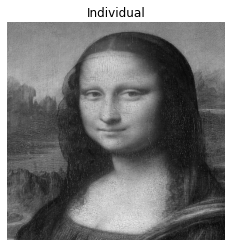

In [34]:
ga = GeneticAlgorithm((None,None), (None,None), (None,None), (None,None), (None,None))
ga.read('images\monalisa.jpg', res=0.06)
# ga.read('images\monalisa.jpg', res=(512,512))
ga.show(ga.goal)